<a href="https://colab.research.google.com/github/StevenLomon/face-recognition-project/blob/Bashir/face_recognition_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import imghdr
from imutils import paths
from matplotlib import pyplot as plt

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [45]:
import shutil

data = pd.read_csv('/Users/yari/2023/Applicerad_AI/fairfacedata/fairface.csv')

main_directory = '/Users/yari/2023/Applicerad_AI/fairfacedata/fairface_images (kopia)'
structured_directory = '/Users/yari/2023/Applicerad_AI/fairfacedata/structured_images'

for index, row in data.iterrows():
    source = os.path.join(main_directory, row['file'])
    race_dir = os.path.join(structured_directory, row['race'])
    if not os.path.exists(race_dir):
        os.makedirs(race_dir)
    destination = os.path.join(race_dir, row['file'])
    if os.path.exists(source):
        shutil.move(source, destination)
    else:
        print(f'file could not be found and skipped: {source}')

file could not be found and skipped: /Users/yari/2023/Applicerad_AI/fairfacedata/fairface_images (kopia)/28544.jpg
file could not be found and skipped: /Users/yari/2023/Applicerad_AI/fairfacedata/fairface_images (kopia)/31948.jpg
file could not be found and skipped: /Users/yari/2023/Applicerad_AI/fairfacedata/fairface_images (kopia)/3339.jpg
file could not be found and skipped: /Users/yari/2023/Applicerad_AI/fairfacedata/fairface_images (kopia)/34114.jpg
file could not be found and skipped: /Users/yari/2023/Applicerad_AI/fairfacedata/fairface_images (kopia)/47808.jpg
file could not be found and skipped: /Users/yari/2023/Applicerad_AI/fairfacedata/fairface_images (kopia)/56453.jpg


In [39]:
data.head()

,file,age,gender,race,phototype
0,1.jpg,50-59,Male,East Asian,III
1,10.jpg,30-39,Male,Middle Eastern,V
2,100.jpg,20-29,Female,East Asian,III
3,1000.jpg,30-39,Male,White,I & II
4,10004.jpg,40-49,Male,Indian,V


In [54]:
images = tf.keras.utils.image_dataset_from_directory('/Users/yari/2023/Applicerad_AI/fairfacedata/structured_images')

Found 35424 files belonging to 7 classes.


In [55]:
image_iterator = images.as_numpy_iterator()

In [85]:

batch = image_iterator.next()

In [62]:
#images represented as numpy array
batch[0].shape

(32, 256, 256, 3)

In [86]:
batch[1] # this is the clauses i vår fall label for olika ras. 

array([1, 6, 1, 5, 0, 2, 1, 0, 6, 6, 6, 1, 3, 0, 6, 1, 0, 5, 5, 4, 3, 3,
       3, 4, 3, 6, 6, 6, 1, 2, 5, 1], dtype=int32)

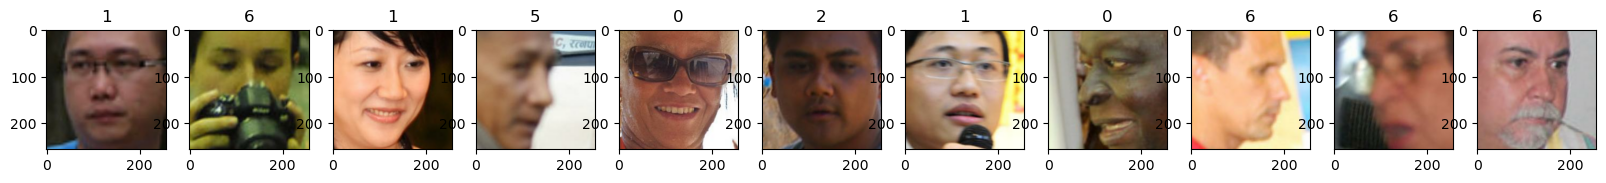

In [87]:
fig, ax = plt.subplots(ncols=11, figsize = (20,20))
for idx, img in enumerate(batch[0][:11]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
